In [1]:
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse import csc_matrix
from scipy.sparse import lil_matrix
from scipy.sparse import vstack
from scipy.sparse import spdiags
from scipy import sparse, io
from sklearn import cross_validation as cv
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from sklearn.metrics import mean_squared_error
from scipy.sparse import coo_matrix
from math import sqrt
from collections import Counter
import random
import math
import time
import matplotlib.pyplot as plt

In [2]:
users_limit = 1000000
amount_of_songs = 384546

In [3]:
songs = dict()
users = dict()

def getSongNum(song):
    if song not in songs:
        songs[song] = len(songs)
    return songs[song]

def getUserNum(user):
    if user not in users:
        users[user] = len(users)
    return users[user]

In [4]:
user_song_matrix = lil_matrix((users_limit, amount_of_songs), dtype=np.float64)
train_data = lil_matrix((users_limit, amount_of_songs), dtype=np.float64)
test_data = lil_matrix((users_limit, amount_of_songs), dtype=np.float64)
f = open('train_triplets.txt')

train_songs_amount = 0
test_songs_amount = 0

i = 0
for line in f:
    a = line.split('\t')
    userId = a[0]
    songId = a[1]
    count = int(a[2])
    userNum = getUserNum(userId)
    if ((userNum + 1) % (users_limit + 1) == 0):
        break
    count = min(math.log(count + 0.0001), 5)
    user_song_matrix[userNum, getSongNum(songId)] = count
    if (random.randint(1, 10) < 8):
        train_data[userNum, getSongNum(songId)] = count
        train_songs_amount = train_songs_amount + 1
    else:
        test_data[userNum, getSongNum(songId)] = count
        test_songs_amount = test_songs_amount + 1
f.close()

In [5]:
print(train_songs_amount)
print(test_songs_amount)

33213606
14233013


In [6]:
users_limit = len(users) - 1
amount_of_songs = len(songs)
user_song_matrix = user_song_matrix[0:users_limit, 0:amount_of_songs].tocsr()
train_data = train_data[0:users_limit, 0:amount_of_songs].tocsr()
test_data = test_data[0:users_limit, 0:amount_of_songs].tocsr()

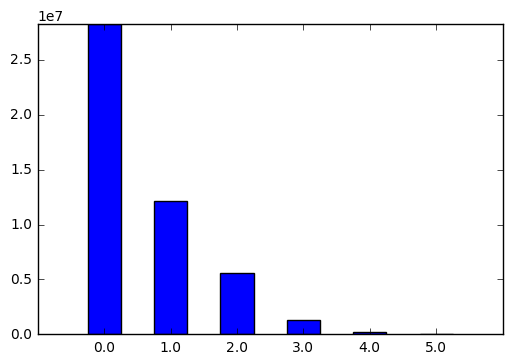

In [7]:
def rate(r):
    return round(r)

d = Counter(map(lambda x: rate(x), list(np.squeeze(np.asarray(user_song_matrix[user_song_matrix.nonzero()].flatten())))))
X = np.arange(len(d))
plt.bar(X, list(map(lambda x: x[1], sorted(zip(d.keys(), d.values())))), align='center', width=0.5)
plt.xticks(X, sorted(d.keys()))
ymax = max(d.values()) + 1
plt.ylim(0, ymax)
plt.show()

In [8]:
print("Source matrix size: " + str(user_song_matrix.data.nbytes / 1024 / 1024) + "MB")

Source matrix size: 361.98897552490234MB


In [9]:
m = 50
batch_size = 30000
song_user_matrix = train_data.T
rows = []
for row_id in range(song_user_matrix.shape[0]):
    if (not (row_id % batch_size == 0)):
        continue
    print(row_id)
    to = min(row_id+batch_size, song_user_matrix.shape[0])
    print(to)
    start_time = time.time()
    batch = song_user_matrix[row_id:to]
    batch = cosine_similarity(batch, song_user_matrix, dense_output=False)
    print(batch.shape)
    t1 = time.time()
    for i in range(batch.shape[0]):
        row = batch[i]
        if row.nnz > m:
            r = row.tolil()
            r[0, row.nonzero()[1][np.argsort(row.data)[-m:]]] = 0
            row = row - r.tocsr()
        rows.append(row)
    t2 = time.time()
    if (row_id % 1000 == 0):
        print(t1 - start_time, t2-t1)
song_song_similarity = normalize(vstack(rows))

0
30000
(30000, 383923)
39.64553689956665 213.89283275604248
30000
60000
(30000, 383923)
16.05339741706848 101.76156902313232
60000
90000
(30000, 383923)
10.488609313964844 65.6609570980072
90000
120000
(30000, 383923)
8.002181768417358 46.98237180709839
120000
150000
(30000, 383923)
6.85744047164917 37.12128520011902
150000
180000
(30000, 383923)
6.170309066772461 30.51886796951294
180000
210000
(30000, 383923)
5.762732744216919 26.124011516571045
210000
240000
(30000, 383923)
5.484688997268677 23.20486855506897
240000
270000
(30000, 383923)
5.283421039581299 20.936770915985107
270000
300000
(30000, 383923)
5.1464009284973145 18.949519395828247
300000
330000
(30000, 383923)
5.037261009216309 17.120428800582886
330000
360000
(30000, 383923)
4.977223873138428 14.350419521331787
360000
383923
(23923, 383923)
4.9141809940338135 8.60005497932434


In [10]:
print("Item-item matrix size: " + str(song_song_similarity.data.nbytes / 1024 / 1024) + "MB")

Item-item matrix size: 138.1854705810547MB


In [11]:
def predict(ratings, similarity):
    return ratings.dot(similarity)

In [12]:
item_prediction = predict(train_data, song_song_similarity)

In [13]:
def rmse(prediction, test_data):
    prediction = prediction[test_data.nonzero()].flatten() 
    test_data = test_data[test_data.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, test_data))
def rmse_with_avg(test_data):
    avg = np.zeros(test_data[test_data.nonzero()].flatten().shape, dtype=np.float64) + train_data.mean()
    test_data = test_data[test_data.nonzero()].flatten()
    return sqrt(mean_squared_error(avg, test_data))

In [14]:
print("RMSE with Simple average: " + str(rmse_with_avg(test_data)))
print('RMSE: ' + str(rmse(item_prediction, test_data)))

RMSE with Simple average: 0.9814520903637297
RMSE: 0.8976200314532233


In [15]:
def plot_errors(prediction, test_data):
    prediction = prediction[test_data.nonzero()].flatten() 
    test_data = test_data[test_data.nonzero()].flatten()
    errors = np.squeeze(np.asarray(prediction - test_data))
    d = Counter(map(lambda x: max(min((round(x * 100) // 50) * 50 / 100, 2.5), -2.5), list(errors)))
    #d = Counter(map(lambda x: (round(x)), list(errors)))
    X = np.arange(len(d))
    plt.bar(X, list(map(lambda x: x[1], sorted(zip(d.keys(), d.values())))), align='center', width=0.5)
    plt.xticks(X, sorted(d.keys()))
    ymax = max(d.values()) + 1
    plt.ylim(0, ymax)
    plt.show()

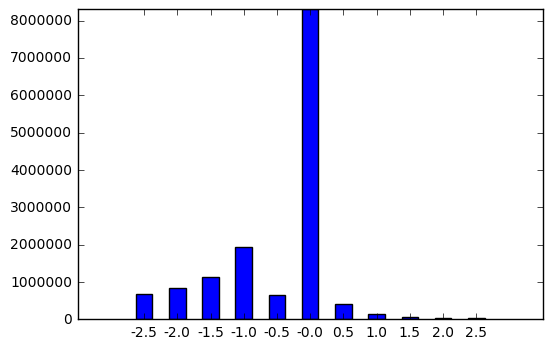

In [16]:
plot_errors(item_prediction, test_data)
